In [1]:
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space', 
              'comp.sys.ibm.pc.hardware', 'sci.crypt']

#학습 데이터셋을 가져옴
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)

print('#Train set size:', len(newsgroups_train.data))
print('#Selected categories:', newsgroups_train.target_names)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


#Train set size: 3219
#Selected categories: ['alt.atheism', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.crypt', 'sci.space', 'talk.religion.misc']


In [2]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(token_pattern="[\w']{3,}", stop_words='english', 
                     max_features=2000, min_df=5, max_df=0.5)
review_cv = cv.fit_transform(newsgroups_train.data) 

In [3]:
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
np.set_printoptions(precision=3)

lda = LatentDirichletAllocation(n_components = 10, #추출할 topic의 수
                                max_iter=5, 
                                topic_word_prior=0.1, doc_topic_prior=1.0,
                                learning_method='online', 
                                n_jobs= -1, #사용 processor 수
                                random_state=0)

review_topics = lda.fit_transform(review_cv)
print('#shape of review_topics:', review_topics.shape)
print('#Sample of review_topics:', review_topics[0])

gross_topic_weights = np.mean(review_topics, axis=0)
print('#Sum of topic weights of documents:', gross_topic_weights)

print('#shape of topic word distribution:', lda.components_.shape)

#shape of review_topics: (3219, 10)
#Sample of review_topics: [0.901 0.007 0.029 0.008 0.007 0.008 0.008 0.007 0.007 0.019]
#Sum of topic weights of documents: [0.09  0.083 0.081 0.114 0.117 0.136 0.085 0.072 0.072 0.151]
#shape of topic word distribution: (10, 2000)


In [4]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
       
        # 위 slicing에서 맨 뒤 -1은 역순을 의미, 역순으로 했을 때 처음부터 n_top_words까지
    print()

print_top_words(lda,cv.get_feature_names_out(), 10)

Topic #0: com, morality, keith, article, sgi, think, sandvik, caltech, objective, moral
Topic #1: image, graphics, file, files, ftp, available, software, use, data, pub
Topic #2: space, access, launch, earth, orbit, digex, lunar, shuttle, satellite, com
Topic #3: article, com, just, like, don't, university, i'm, nntp, host, posting
Topic #4: key, clipper, chip, encryption, com, government, law, keys, use, escrow
Topic #5: scsi, com, posting, nntp, host, thanks, bit, university, ibm, know
Topic #6: nasa, gov, university, host, posting, nntp, ___, distribution, center, washington
Topic #7: drive, com, disk, hard, controller, drives, dos, tape, problem, floppy
Topic #8: key, public, mail, faq, message, pgp, group, des, posting, university
Topic #9: god, people, don't, jesus, just, believe, say, does, think, know



n_components: 6, perplexity: 1063.362
n_components: 7, perplexity: 1045.636
n_components: 8, perplexity: 1015.561
n_components: 9, perplexity: 1016.494
n_components: 10, perplexity: 1028.560
n_components: 11, perplexity: 1036.692
n_components: 12, perplexity: 1032.437
n_components: 13, perplexity: 1038.319
n_components: 14, perplexity: 1040.664
n_components: 15, perplexity: 1046.556


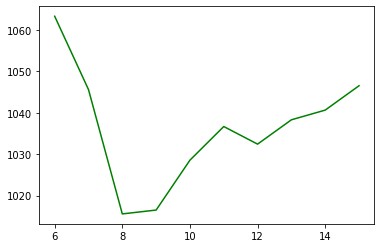

n_components with minimum perplexity: 8


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_perplexity(cv, start=10, end=30, max_iter=5, topic_word_prior= 0.1, 
                    doc_topic_prior=1.0):
    iter_num = []
    per_value = []

    for i in range(start, end + 1):
        lda = LatentDirichletAllocation(n_components = i, max_iter=max_iter, 
                                        topic_word_prior= topic_word_prior, 
                                        doc_topic_prior=doc_topic_prior,
                                        learning_method='batch', n_jobs= -1,
                                        random_state=7)    
        lda.fit(cv)
        iter_num.append(i)
        pv = lda.perplexity(cv)
        per_value.append(pv)
        print(f'n_components: {i}, perplexity: {pv:0.3f}')

    plt.plot(iter_num, per_value, 'g-')
    plt.show()
    return start + per_value.index(min(per_value))

print("n_components with minimum perplexity:",
      show_perplexity(review_cv, start=6, end=15))

In [6]:
lda = LatentDirichletAllocation(n_components=8, # 추출할 topic의 수를 지정
                                max_iter=20,
                                topic_word_prior=0.1,
                                doc_topic_prior=1.0,
                                learning_method='batch',
                                n_jobs=-1,
                                random_state=7)

review_topics = lda.fit_transform(review_cv)

print_top_words(lda, cv.get_feature_names_out(), 10)

Topic #0: image, graphics, mail, available, file, ftp, data, files, software, information
Topic #1: nasa, gov, posting, space, university, host, nntp, ___, center, distribution
Topic #2: com, keith, article, morality, think, posting, nntp, caltech, don't, host
Topic #3: com, article, jesus, know, just, posting, host, nntp, don't, i'm
Topic #4: people, god, does, don't, think, say, believe, just, way, like
Topic #5: drive, scsi, card, com, disk, thanks, ide, controller, bus, hard
Topic #6: space, access, article, launch, just, year, like, digex, moon, com
Topic #7: key, encryption, clipper, chip, com, government, keys, use, security, public



In [7]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

cachedStopWords = stopwords.words("english")

RegTok = RegexpTokenizer("[\w']{3,}")
english_stops = set(stopwords.words('english'))

def tokenizer(text):
  tokens = RegTok.tokenize(text.lower())
  words = [word for word in tokens if (word not in english_stops) and len(word) > 2]
  return words

texts = [tokenizer(news) for news in newsgroups_train.data]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
from gensim.corpora.dictionary import Dictionary

# 토큰화 결과로부터 dictionay 생성
dictionary = Dictionary(texts)
print('#Number of initial unique words in documents:', len(dictionary))

# 문서 빈도수가 너무 적거나 높은 단어를 필터링하고 특성을 단어의 빈도 순으로 선택
dictionary.filter_extremes(keep_n=2000, no_below=5, no_above=0.5)
print('#Number of unique words after removing rare and common words:', len(dictionary))

# 카운트 벡터로 변환
corpus = [dictionary.doc2bow(text) for text in texts]
print('#Number of unique tokens: %d' % len(dictionary))
print('#Number of documents: %d' % len(corpus))

#Number of initial unique words in documents: 46466
#Number of unique words after removing rare and common words: 2000
#Number of unique tokens: 2000
#Number of documents: 3219


In [10]:
from gensim.models import LdaModel

num_topics = 10
passes = 5
%time model = LdaModel(corpus=corpus, id2word=dictionary,\
                       passes=passes, num_topics=num_topics, \
                       random_state=7)

CPU times: user 26.4 s, sys: 203 ms, total: 26.6 s
Wall time: 45.5 s


In [11]:
model.print_topics(num_words=10)

[(0,
  '0.023*"com" + 0.018*"keith" + 0.016*"caltech" + 0.013*"sgi" + 0.013*"nntp" + 0.013*"posting" + 0.013*"host" + 0.012*"would" + 0.012*"system" + 0.011*"livesey"'),
 (1,
  '0.020*"morality" + 0.018*"objective" + 0.015*"one" + 0.015*"say" + 0.014*"uiuc" + 0.012*"frank" + 0.012*"values" + 0.010*"faq" + 0.010*"article" + 0.008*"cso"'),
 (2,
  '0.026*"com" + 0.025*"access" + 0.025*"posting" + 0.023*"host" + 0.023*"nntp" + 0.017*"digex" + 0.015*"article" + 0.013*"cwru" + 0.013*"___" + 0.013*"net"'),
 (3,
  '0.021*"university" + 0.017*"posting" + 0.015*"host" + 0.015*"nntp" + 0.013*"article" + 0.010*"com" + 0.009*"know" + 0.009*"i\'m" + 0.009*"would" + 0.009*"thanks"'),
 (4,
  '0.032*"com" + 0.015*"would" + 0.011*"article" + 0.010*"one" + 0.010*"get" + 0.009*"people" + 0.009*"ibm" + 0.008*"government" + 0.007*"good" + 0.007*"i\'m"'),
 (5,
  '0.025*"key" + 0.017*"encryption" + 0.014*"clipper" + 0.014*"chip" + 0.009*"keys" + 0.009*"use" + 0.008*"security" + 0.008*"government" + 0.008*"pub

In [12]:
print("#topic distribution of the first document: ", model.get_document_topics(corpus[0]))

#topic distribution of the first document:  [(0, 0.72576934), (8, 0.2699505)]


In [15]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# LDA 모형을 pyLDAvis 객체에 전달
lda_viz = gensimvis.prepare(model, corpus, dictionary)
lda_viz

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.137200  0.040249       1        1  22.655416
5      0.065990  0.123620       2        1  14.522776
9      0.072133  0.092872       3        1  12.987437
7      0.138320  0.043609       4        1  11.020437
4     -0.021828  0.007495       5        1   9.298365
6      0.072783 -0.094709       6        1   9.118869
3      0.027374 -0.054949       7        1   8.494165
0     -0.040786 -0.129974       8        1   4.524071
2      0.005359 -0.091972       9        1   4.051827
1     -0.182144  0.063761      10        1   3.326637, topic_info=            Term         Freq        Total Category  logprob  loglift
538        space  1487.000000  1487.000000  Default  30.0000  30.0000
20           com  3752.000000  3752.000000  Default  29.0000  29.0000
834          key  1316.000000  1316.000000  Default  28.0000  28.0000
1551        scsi   741.000000   741.000000  Default  27.0000  27.0000
70       posting  1723.000000  1723.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
65        people    64.445774  1672.571326  Topic10  -5.1558   0.1469
789          sci    53.265337   309.474053  Topic10  -5.3463   1.6436
602   university    56.862740  1487.218103  Topic10  -5.2810   0.1392
294         time    55.767882  1187.715297  Topic10  -5.3004   0.3446
315       better    54.193100   564.543676  Topic10  -5.3290   1.0597

[592 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1359      1  0.006274      128
1359      2  0.069013      128
1359      3  0.037643      128
1359      4  0.878342      128
153       1  0.057463     1993
...     ...       ...      ...
343       8  0.022394    years
343       9  0.005599    years
343      10  0.121303    years
704       3  0.991487      zoo
705       3  0.984036  zoology

[2804 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 6, 10, 8, 5, 7, 4, 1, 3, 2])

In [16]:
from gensim.models import CoherenceModel

cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()
print(coherence)

-1.7493528544065975


num_topics: 6, perplexity: -7.035, coherence: -1.701


num_topics: 7, perplexity: -7.023, coherence: -1.735


num_topics: 8, perplexity: -7.023, coherence: -1.547


num_topics: 9, perplexity: -7.007, coherence: -1.891


num_topics: 10, perplexity: -6.996, coherence: -1.888


num_topics: 11, perplexity: -7.027, coherence: -2.164


num_topics: 12, perplexity: -7.019, coherence: -2.018


num_topics: 13, perplexity: -7.025, coherence: -2.255


num_topics: 14, perplexity: -7.020, coherence: -2.082
num_topics: 15, perplexity: -7.019, coherence: -2.521


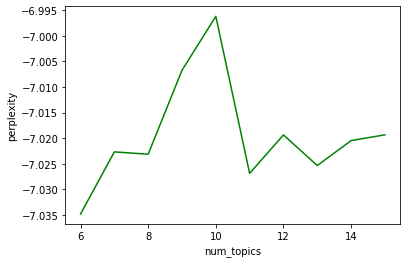

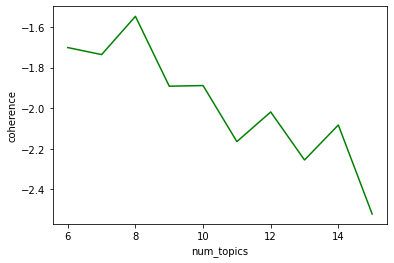

In [18]:
def show_coherence(corpus, dictionary, start=6, end=15):
  iter_num = []
  per_value = []
  coh_value = []

  for i in range(start, end + 1):
    model = LdaModel(corpus=corpus, id2word=dictionary,
                     chunksize=1000, num_topics=i,
                     random_state=7)
    iter_num.append(i)
    pv = model.log_perplexity(corpus)
    per_value.append(pv)

    cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
    cv = cm.get_coherence()
    coh_value.append(cv)
    print(f'num_topics: {i}, perplexity: {pv:0.3f}, coherence: {cv:0.3f}')
  
  plt.plot(iter_num, per_value, 'g-')
  plt.xlabel("num_topics")
  plt.ylabel("perplexity")
  plt.show()

  plt.plot(iter_num, coh_value, 'g-')
  plt.xlabel("num_topics")
  plt.ylabel("coherence")
  plt.show()

show_coherence(corpus, dictionary, start=6, end=15)

In [32]:
!pip install wget

import os
import wget
import ssl

data_dir = 'data'
url = 'https://s3.ap-northeast-2.amazonaws.com/data10902/petition/petition_sampled.csv'
ssl._create_default_https_context = ssl._create_unverified_context

if not os.path.exists(data_dir):
    os.mkdir(data_dir)

wget.download(url, data_dir)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=49526bd911d1c123070800fc89b057c2816d9758b42fac3f84845f28b672b2f1
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


'data/petition_sampled.csv'

In [33]:
import pandas as pd

df = pd.read_csv("./data/petition_sampled.csv") #read data
df.iloc[[2]]

,article_id,start,end,answered,votes,category,title,content
2,136,2017-08-20,2017-11-18,0,4,육아/교육,고등학교 교육 내용 수준을 낮춰주시고 실용적인 내용을 담아주세요!,저는 광주에 사는 중3 학생입니다. 고등학교 가기 직전의 학년이라 어느 때보다 고등...


In [38]:
from sklearn.feature_extraction.text import CountVectorizer
from konlpy.tag import Okt 
twit = Okt()

def tokenizer(doc):
    return [token for token in twit.nouns(doc) if len(token) > 1]

vec = CountVectorizer(tokenizer=tokenizer, # 우선은 명사만 사용
                      max_df=0.5, min_df = 5, 
                      max_features = 1000) # 적당한 대상 단어 수를 선택

pet_cv = vec.fit_transform(df.content)
print(pet_cv.shape)

(18077, 1000)


In [39]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components = 15, \
                                n_jobs= -1, \
                                random_state = 0)

%time pet_topics = lda.fit_transform(pet_cv)

def print_top_words(model, feature_names, n_top_words):
  for topic_idx, topic in enumerate(model.components_):
    print("Topic #%d: " % topic_idx, end='')
    print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

print_top_words(lda,vec.get_feature_names_out(), 15)

CPU times: user 3.19 s, sys: 272 ms, total: 3.46 s
Wall time: 2min 17s
Topic #0: 사람, 생각, 병원, 대통령, 피해자, 국민, 사건, 정말, 가족, 나라, 환자, 자신, 인간, 지금, 의사
Topic #1: 북한, 우리, 한국, 대통령, 정부, 국민, 대한민국, 미국, 일본, 문재인, 국가, 문제, 생각, 나라, 우리나라
Topic #2: 아이, 부모, 어린이집, 생각, 교사, 엄마, 우리, 유치원, 자녀, 가정, 동물, 출산, 아빠, 문제, 지원
Topic #3: 청소년, 불법, 폐지, 보호, 장애인, 조직, 사찰, 생각, 외국인, 이용, 노인, 사회, 나이, 범죄, 사람
Topic #4: 정부, 주택, 정책, 국민, 부동산, 서민, 아파트, 나라, 대통령, 세금, 지금, 사람, 투기, 집값, 임대
Topic #5: 일자리, 기업, 근무, 정부, 생각, 근로자, 지원, 임금, 최저임금, 시간, 정책, 회사, 직원, 대기업, 고용
Topic #6: 국민, 청원, 국회의원, 국회, 의원, 청와대, 세금, 반대, 생각, 건강, 동의, 제도, 대통령, 답변, 국가
Topic #7: 관리, 내용, 대한, 조사, 관련, 판결, 공사, 사실, 업무, 판사, 확인, 해당, 주민, 발생, 민원
Topic #8: 학생, 학교, 교육, 선수, 시험, 생각, 대학, 공부, 문제, 교사, 선생님, 시간, 제도, 위해, 고등학교
Topic #9: 보험, 연금, 국민연금, 공무원, 지급, 방송, 국민, 소득, 가입, 국가, 기초, 보험료, 공단, 군인, 수급
Topic #10: 여성, 공무원, 사회, 대한민국, 생각, 남성, 사람, 남자, 행정, 국민, 나라, 여자, 의무, 군대, 국가
Topic #11: 경찰, 범죄, 국민, 사건, 위해, 대한민국, 조직, 불법, 수사, 만행, 범죄자, 경찰서, 부정부패, 검찰, 살인마
Topic #12: 처벌, 피해자, 사건, 차량, 사고, 피해, 가해자, 범죄, 경우, 대한, 기사,

In [40]:
trend_data = pd.DataFrame(pet_topics, columns=['Topic'+str(i) for i in range(1, 16)])
trend_data = pd.concat([trend_data, df.start.map(lambda x: x[:7])], axis=1)
trend_data.iloc[:5, -5:]

,Topic12,Topic13,Topic14,Topic15,start
0,0.000307,0.000307,0.000307,0.000307,2017-08
1,0.000813,0.000813,0.000813,0.559732,2017-08
2,0.001449,0.001449,0.001449,0.001449,2017-08
3,0.000227,0.000227,0.000227,0.026129,2017-08
4,0.000447,0.035637,0.000447,0.000447,2017-08


In [41]:
trend = trend_data.groupby(['start']).mean()
trend.iloc[:5, -5:]

,Topic11,Topic12,Topic13,Topic14,Topic15
start,,,,,
2017-08,0.043216,0.015766,0.025389,0.024661,0.110004
2017-09,0.042948,0.023563,0.104047,0.019750,0.040786
2017-10,0.083816,0.053574,0.064864,0.032247,0.097858
2017-11,0.045919,0.045047,0.221295,0.045477,0.048018
2017-12,0.059587,0.027359,0.075098,0.050710,0.076128


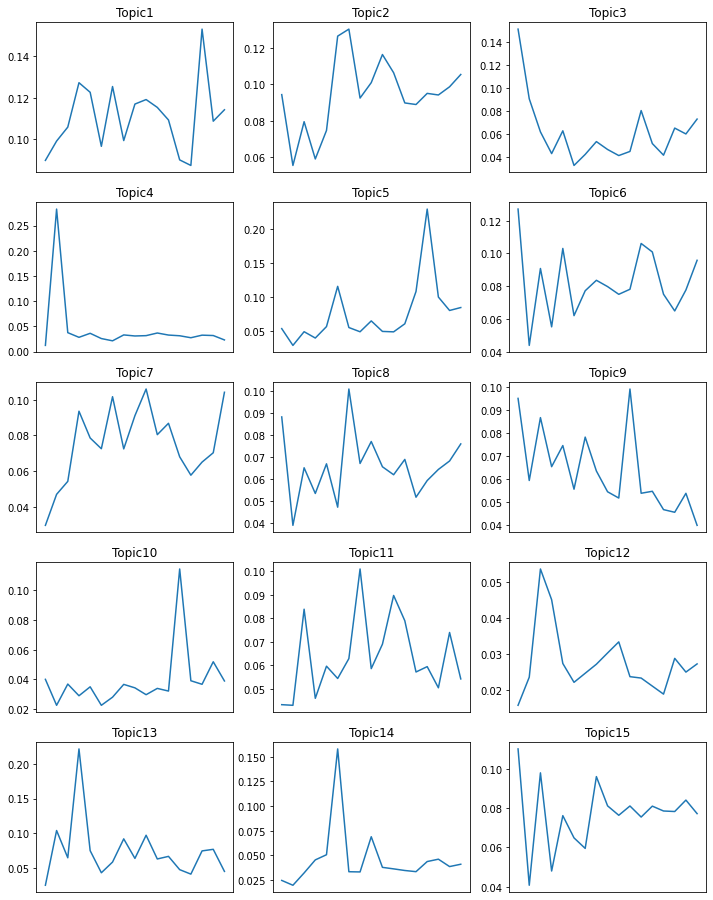

In [42]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(5, 3, sharex='col', figsize=(12, 16)) 
for col, ax in zip(trend.columns.tolist(), axes.ravel()): 
    ax.set_title(col)
    ax.axes.xaxis.set_visible(False)
    ax.plot(trend[col])
plt.show()